In [1]:
regressors_to_remove = ["destinationMacAddress", "sourceMacAddress", "egressInterface", "ingressInterface", "initialTCPFlags", 
                    "reverseInitialTCPFlags", "reverseTcpUrgTotalCount", "reverseUnionTCPFlags", "silkAppLabel", 
                    "tcpSequenceNumber", "tcpUrgTotalCount", "unionTCPFlags", "vlanId", "sourceIPv4Address", 
                    "destinationIPv4Address", "reverseTcpSequenceNumber", "observationDomainId", "reverseStandardDeviationInterarrivalTime",
                    "reverseStandardDeviationPayloadLength", "reverseSmallPacketCount", "reverseNonEmptyPacketCount",
                    "reverseMaxPacketSize", "reverseLargePacketCount", "reverseFirstNonEmptyPacketSize", "reverseDataByteCount",
                    "reverseBytesPerPacket", "reverseAverageInterarrivalTime", "collectorName"]

regressor_has_null = ["protocolIdentifier"]

In [2]:
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType, LongType, TimestampType

schema = StructType([
    StructField("averageInterarrivalTime", DoubleType(), True),
    StructField("bytesPerPacket", DoubleType(), True),
    StructField("dataByteCount", DoubleType(), True),
    StructField("destinationTransportPort", IntegerType(), True),
    StructField("firstEightNonEmptyPacketDirections", StringType(), True),
    StructField("firstNonEmptyPacketSize", DoubleType(), True),
    StructField("flowAttributes", StringType(), True),
    StructField("flowDurationMilliseconds", DoubleType(), True),
    StructField("flowEndMilliseconds", TimestampType(), True),
    StructField("flowEndReason", StringType(), True),
    StructField("flowStartMilliseconds", TimestampType(), True),
    StructField("ipClassOfService", StringType(), True),
    StructField("largePacketCount", DoubleType(), True),
    StructField("maxPacketSize", DoubleType(), True),
    StructField("nonEmptyPacketCount", DoubleType(), True),
    StructField("octetTotalCount", IntegerType(), True),
    StructField("packetTotalCount", IntegerType(), True),
    StructField("protocolIdentifier", IntegerType(), True),
    StructField("reverseFlowAttributes", StringType(), True),
    StructField("reverseFlowDeltaMilliseconds", DoubleType(), True),
    StructField("reverseOctetTotalCount", IntegerType(), True),
    StructField("reversePacketTotalCount", IntegerType(), True),
    StructField("smallPacketCount", DoubleType(), True),
    StructField("sourceTransportPort", IntegerType(), True),
    StructField("standardDeviationInterarrivalTime", DoubleType(), True),
    StructField("standardDeviationPayloadLength", DoubleType(), True),
    StructField("response", StringType(), True)
])

In [2]:
import os
import re
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("cleanData").getOrCreate()



folder_path = 'C:\\Users\\Priyash Shah\\Downloads\\DATA3001 Project Data\\Extracted Data'
data_lengths = []
# Get all files in the directory
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

#df = spark.createDataFrame(spark.sparkContext.emptyRDD(),schema)
df = pd.DataFrame()
for file in files:
    print(f"in file {file}")
    file_path = folder_path+'\\'+file
    data = []
    length = 0
    ### TEMP
    dataset = open(file_path)
    
    # Read file line by line based on date
    for line in dataset:
        obj = json.loads(line)
        
        if 'flows' in obj:
           
            dateflow = obj['flows']['flowEndMilliseconds']
            if dateflow > "2019-07-26":
                break
            length += 1    
            data.append(obj['flows'])
        else:
            break
    
    response = re.sub('([^.]*).json$', r'\1', file)
    data_info = (response, length)        
    data_lengths.append(data_info)
    
    # Assuming data is already loaded
    temp_df = pd.DataFrame(data)

    # Sampling
    temp_df = temp_df.sample(n = 4500, random_state=69)

    # print(temp_df.columns)
    # Dropping columns
    for regressors in regressors_to_remove:
        temp_df = temp_df.drop(columns=regressors)

    # Dropping rows with all NaN values in the specified columns
    for regressors in regressor_has_null:
        temp_df = temp_df.dropna(how='all', subset=[regressors])
    temp_df['response'] = response    
    df = pd.concat([df, temp_df], ignore_index=True)
            
    '''       
    temp_df = spark.createDataFrame(data)
    
    sample_length = 4500 / len(data)
    temp_df = temp_df.sample(sample_length)
    temp_df.count()
    #print(obj.columns)
    #temp_df = pd.json_normalize(data)
    #temp_df = temp_df.sample(fraction=0.1, seed=69)
    for regressors in regressors_to_remove:
        temp_df = temp_df.drop(regressors)
    for regressors in regressor_has_null:  
        temp_df = temp_df.na.drop('all', subset=[regressors])
    response = re.sub('([^.]*).json$', r'\1', file)
    temp_df = temp_df.withColumn("response", lit(response))
    '''
    
   
    
    
    #pandas_df = temp_df.toPandas()
    
    #df = df.append(new_row, ignore_index=True)
    
    #df = df.union(temp_df)
    

in file amazon_echo_gen2.json
in file au_network_camera.json
in file au_wireless_adapter.json
in file bitfinder_awair_breathe_easy.json
in file candy_house_sesami_wi-fi_access_point.json
in file irobot_roomba.json
in file jvc_kenwood_hdtv_ip_camera.json
in file line_clova_wave.json
in file link_japan_eremote.json
in file mouse_computer_room_hub.json
in file nature_remo.json
in file panasonic_doorphone.json
in file philips_hue_bridge.json
in file planex_camera_one_shot!.json
in file planex_smacam_outdoor.json
in file planex_smacam_pantilt.json
in file powerelectric_wi-fi_plug.json
in file qrio_hub.json
in file sony_network_camera.json


In [3]:
data_lengths

[('amazon_echo_gen2', 142356),
 ('au_network_camera', 71903),
 ('au_wireless_adapter', 154371),
 ('bitfinder_awair_breathe_easy', 68896),
 ('candy_house_sesami_wi-fi_access_point', 46116),
 ('irobot_roomba', 40818),
 ('jvc_kenwood_hdtv_ip_camera', 42982),
 ('line_clova_wave', 64244),
 ('link_japan_eremote', 70545),
 ('mouse_computer_room_hub', 4610),
 ('nature_remo', 40867),
 ('panasonic_doorphone', 357568),
 ('philips_hue_bridge', 72750),
 ('planex_camera_one_shot!', 430580),
 ('planex_smacam_outdoor', 48014),
 ('planex_smacam_pantilt', 33523),
 ('powerelectric_wi-fi_plug', 78091),
 ('qrio_hub', 51951),
 ('sony_network_camera', 45014)]

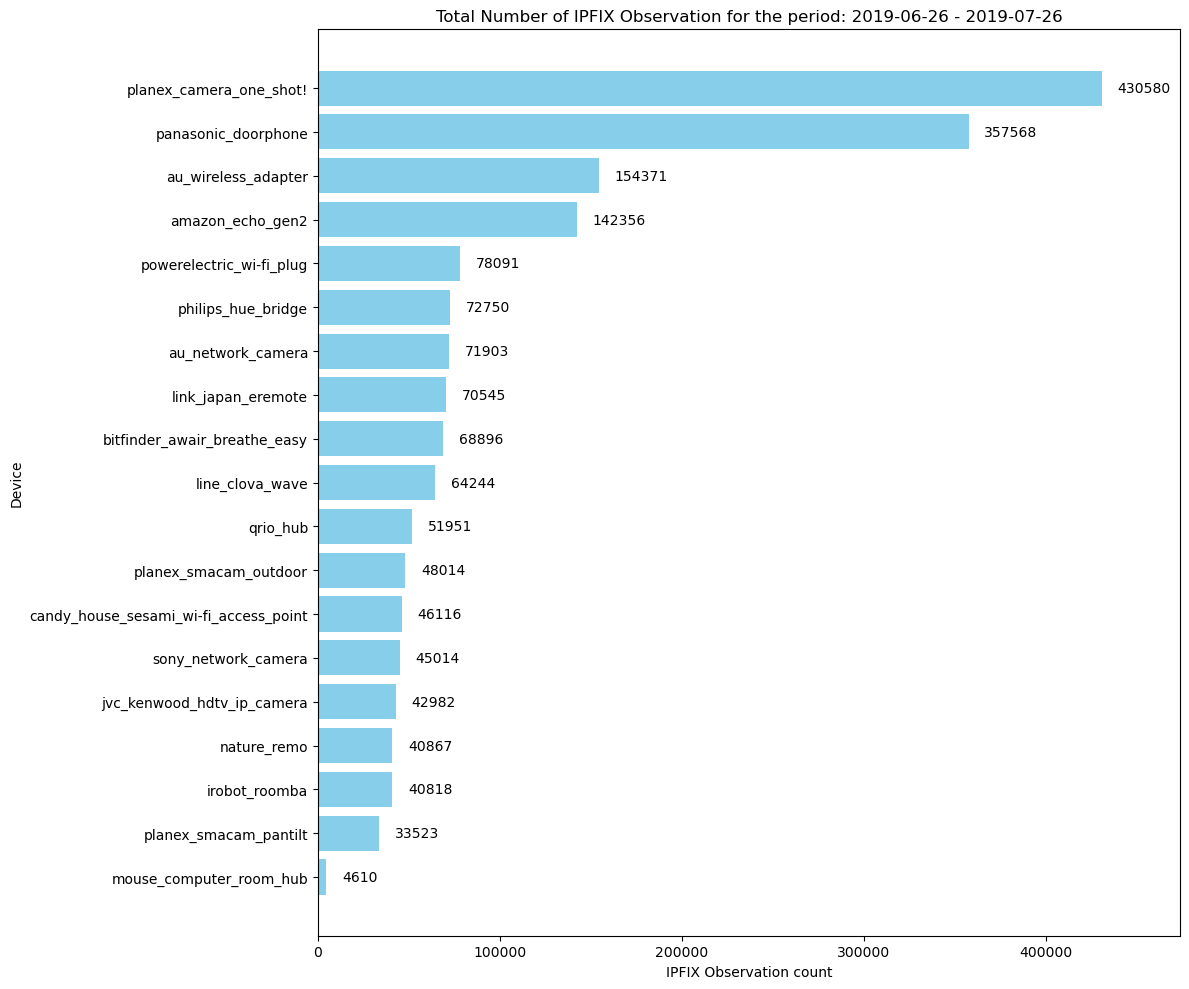

In [3]:
import matplotlib.pyplot as plt


data_lengths = pd.DataFrame(data_lengths, columns=['Name', 'Count'])

# Sort by Count
data_lengths = data_lengths.sort_values('Count', ascending=True)

plt.figure(figsize=(12, 10))
bars = plt.barh(data_lengths['Name'], data_lengths['Count'], color='skyblue')

# Set the x-axis limit to accommodate the annotations (e.g., increase by 10%)
plt.xlim(0, data_lengths['Count'].max() * 1.1)

# Annotate each bar with its exact count
for bar in bars:
    plt.text(bar.get_width() + (0.02 * data_lengths['Count'].max()),  # Position the text a bit right from the bar's end
             bar.get_y() + bar.get_height()/2,  # Y location in the middle of the bar
             f'{int(bar.get_width())}',  # Value to display
             va='center', ha='left',  # Vertical and horizontal alignment
             color='black', fontsize=10)

plt.xlabel('IPFIX Observation count')
plt.ylabel('Device')
plt.title('Total Number of IPFIX Observation for the period: 2019-06-26 - 2019-07-26')
plt.tight_layout()
plt.show()



In [4]:
ordered_protcol_identifiers = df['protocolIdentifier'].value_counts()

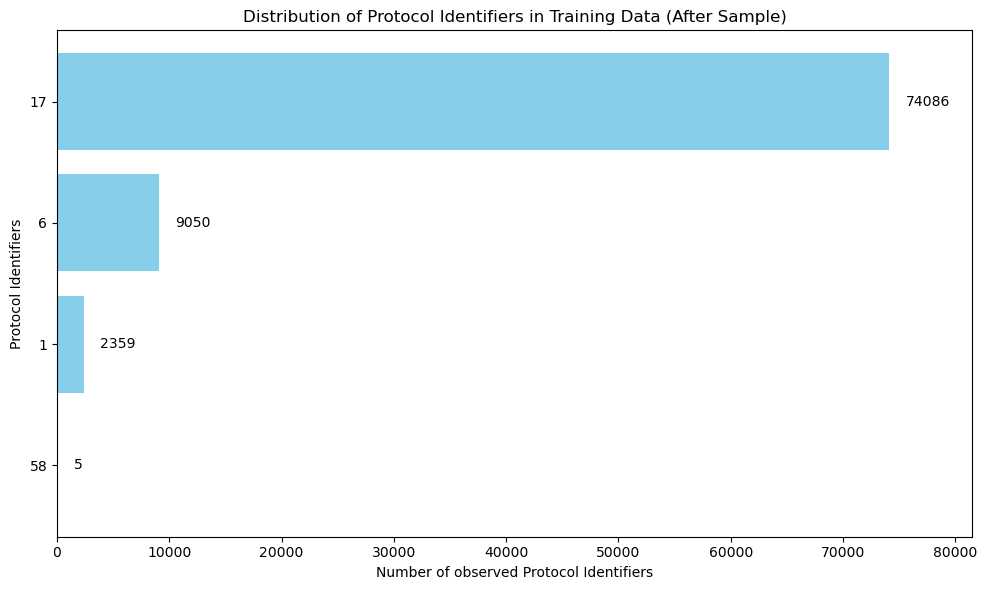

In [5]:
plt.figure(figsize=(10, 6))
ordered_protcol_identifiers = {
    'Category': [17, 6, 1, 58],
    'Count': [74086, 9050, 2359, 5]
}

ordered_protcol_identifiers = pd.DataFrame(ordered_protcol_identifiers)
ordered_protcol_identifiers = ordered_protcol_identifiers.sort_values('Count', ascending=True)
ordered_protcol_identifiers['Category'] = ordered_protcol_identifiers['Category'].astype(str)

bars = plt.barh(ordered_protcol_identifiers['Category'], ordered_protcol_identifiers['Count'], color='skyblue')



# Set the x-axis limit to accommodate the annotations (e.g., increase by 10%)
plt.xlim(0, ordered_protcol_identifiers['Count'].max() * 1.1)

# Annotate each bar with its exact count
for bar in bars:
    plt.text(bar.get_width() + (0.02 * ordered_protcol_identifiers['Count'].max()),  # Position the text a bit right from the bar's end
             bar.get_y() + bar.get_height()/2,  # Y location in the middle of the bar
             f'{int(bar.get_width())}',  # Value to display
             va='center', ha='left',  # Vertical and horizontal alignment
             color='black', fontsize=10)

plt.xlabel('Number of observed Protocol Identifiers')
plt.ylabel('Protocol Identifiers')
plt.title('Distribution of Protocol Identifiers in Training Data (After Sample)')
plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

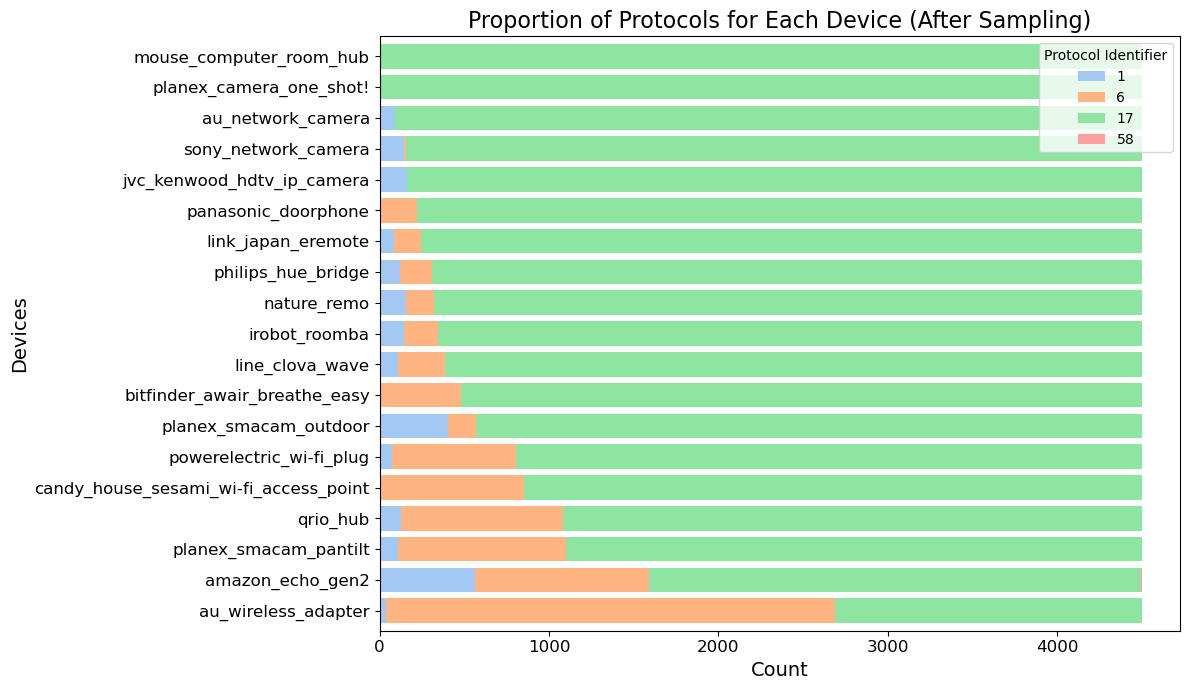

In [29]:
import seaborn as sns
pivot_df = df.groupby(['response', 'protocolIdentifier']).size().unstack().fillna(0)

# Sort by protocol '17' and then '6'
pivot_df = pivot_df.sort_values(by=[17, 1, 6], ascending=[True, True, True])


# Set a color palette (light-themed)
palette = sns.color_palette("pastel")

# Plot
plt.figure(figsize=(12, 7))

# Using the color palette in the stacked horizontal bar plot
pivot_df.plot(kind='barh', stacked=True, color=palette, figsize=(12, 7), width=0.8)

# Set title, labels, legend
plt.title('Proportion of Protocols for Each Device (After Sampling)', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Devices', fontsize=14)
plt.legend(title='Protocol Identifier', fontsize=10)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


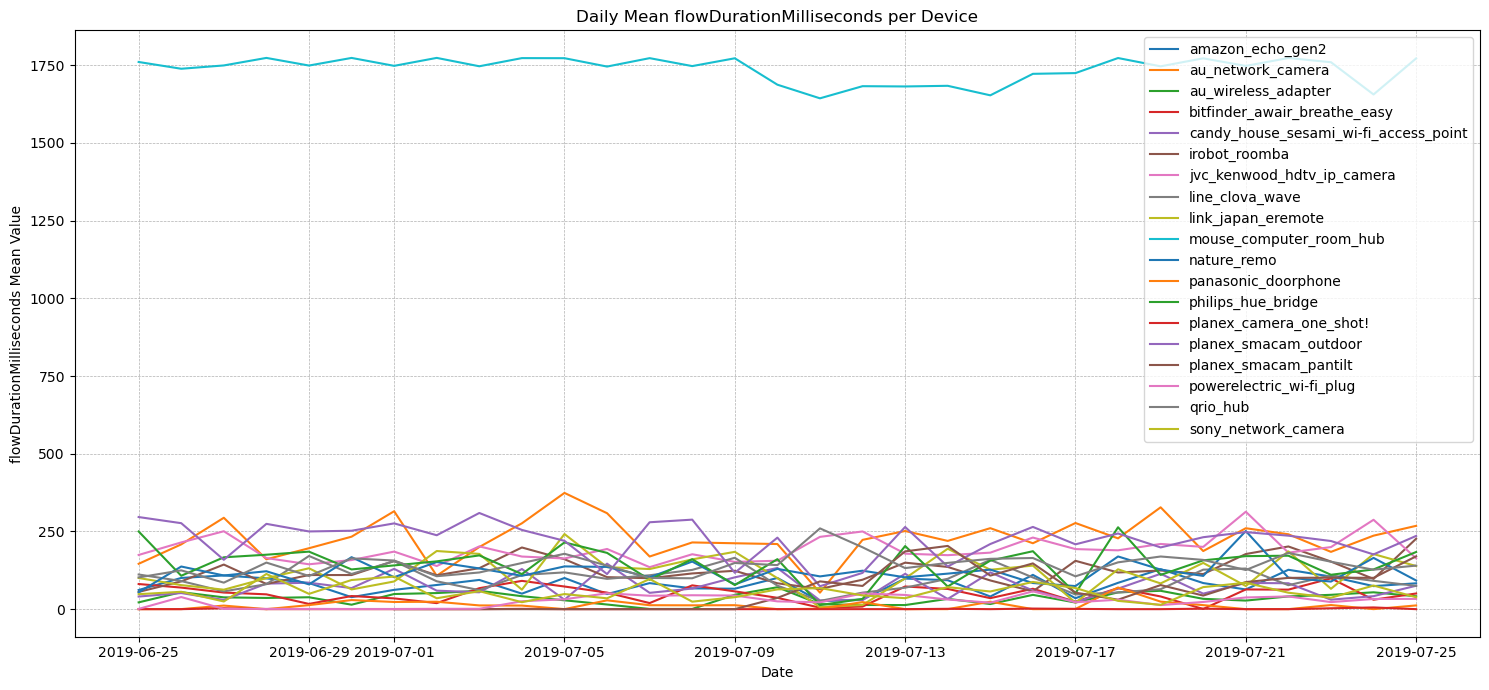

In [77]:
import matplotlib.pyplot as plt

# Observing the flow duratation for each device

# Convert flowStartMilliseconds column to datetime format
df['flowStartMilliseconds'] = pd.to_datetime(df['flowStartMilliseconds'])

# Group the data by 'response' and date, then get the mean of 'flowDurationMilliseconds' for each group
flow_by_day = df.groupby(['response', pd.Grouper(key='flowStartMilliseconds', freq='D')])['flowDurationMilliseconds'].mean()
flow_by_day.index.levels[0]
# Create a line plot
plt.figure(figsize=(15, 7))

# Get unique device names from the index
for device in flow_by_day.index.get_level_values('response').unique():
    subset = flow_by_day[device]  # Extract data for each device
    plt.plot(subset, label=device)

plt.title('Daily Mean flowDurationMilliseconds per Device')
plt.xlabel('Date')
plt.ylabel('flowDurationMilliseconds Mean Value')
plt.legend(loc="upper right")
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


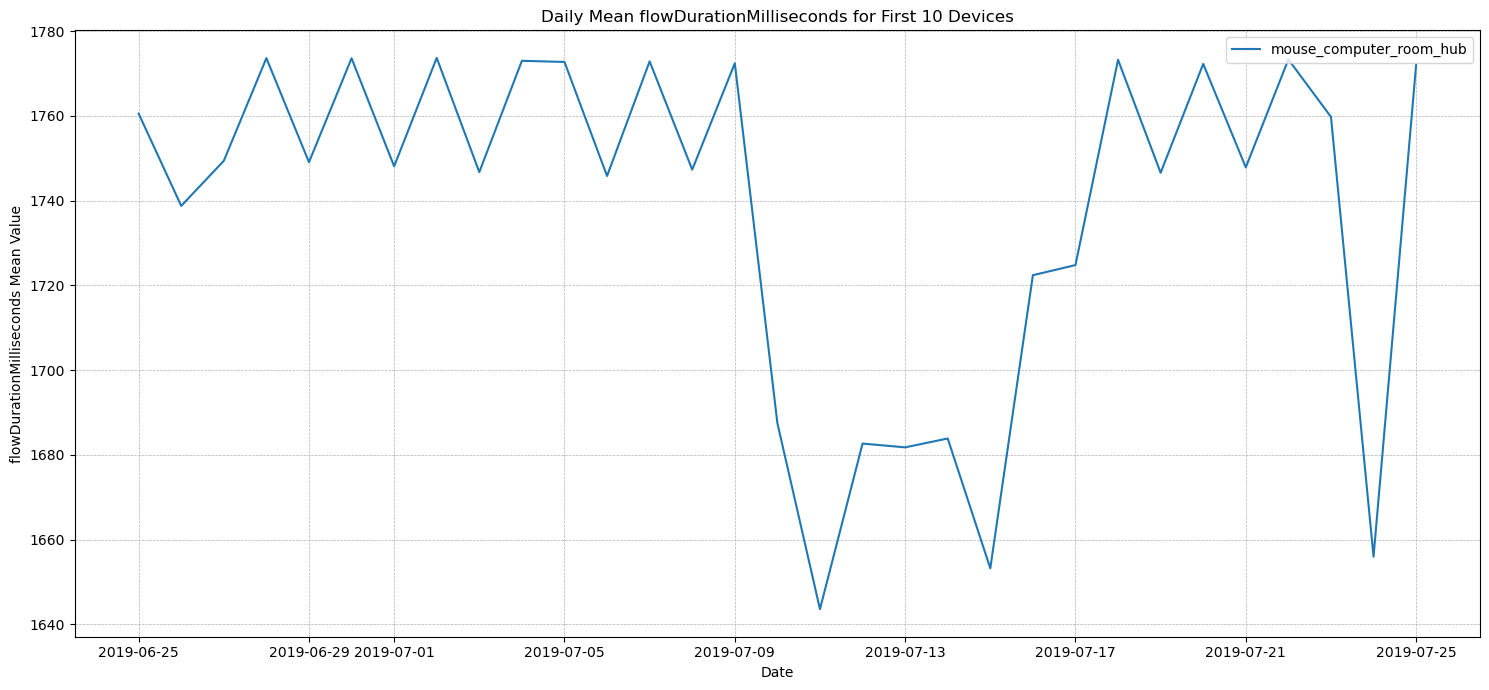

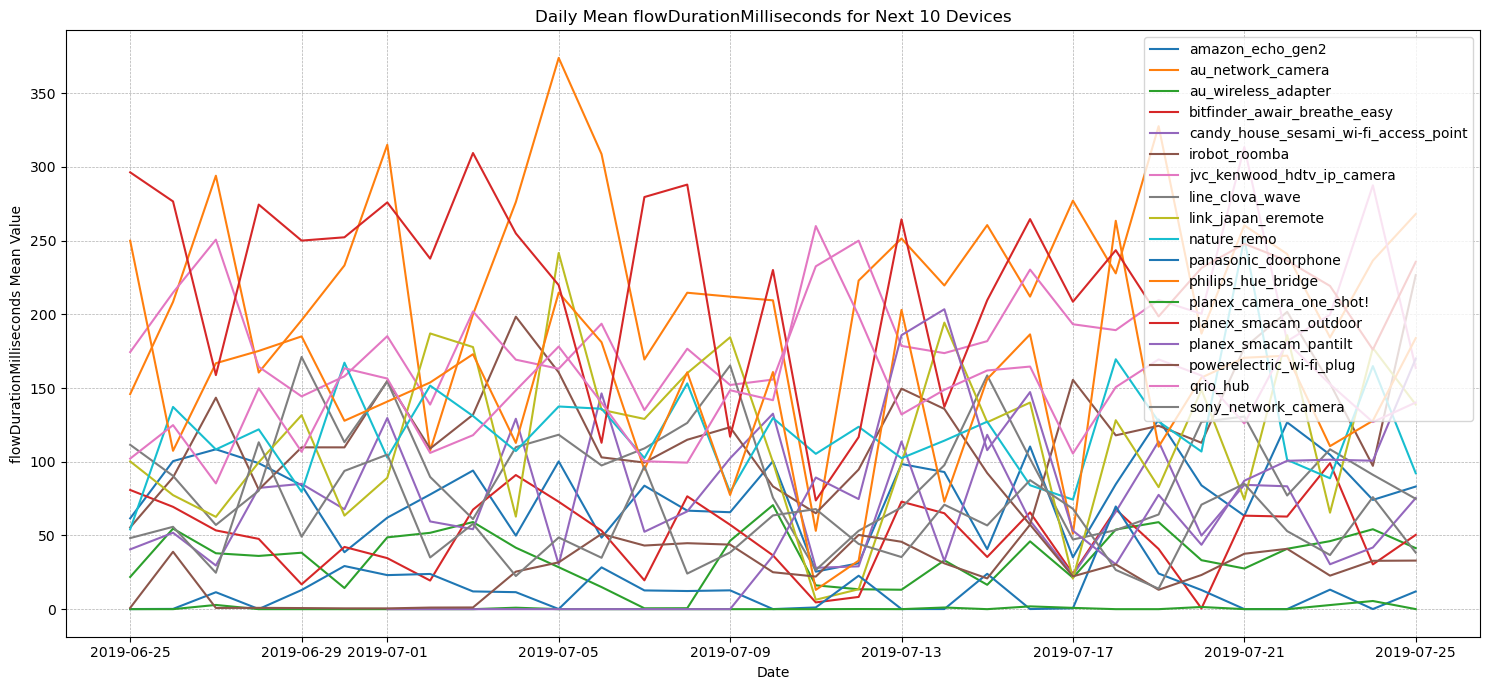

In [79]:
# Get unique device names from the index
device_means = flow_by_day.groupby(level='response').mean()

# Separate devices based on the criteria


devices_above_700 = device_means[device_means >= 700].index
devices_below_700 = device_means[device_means < 700].index

# Function to plot a set of devices
def plot_devices(devices, title):
    plt.figure(figsize=(15, 7))
    for device in devices:
        subset = flow_by_day[device]  # Extract data for each device
        plt.plot(subset, label=device)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('flowDurationMilliseconds Mean Value')
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Plot first 10 devices
plot_devices(devices_above_700, 'Daily Mean flowDurationMilliseconds for First 10 Devices')

# Plot next 10 devices
plot_devices(devices_below_700, 'Daily Mean flowDurationMilliseconds for Next 10 Devices')



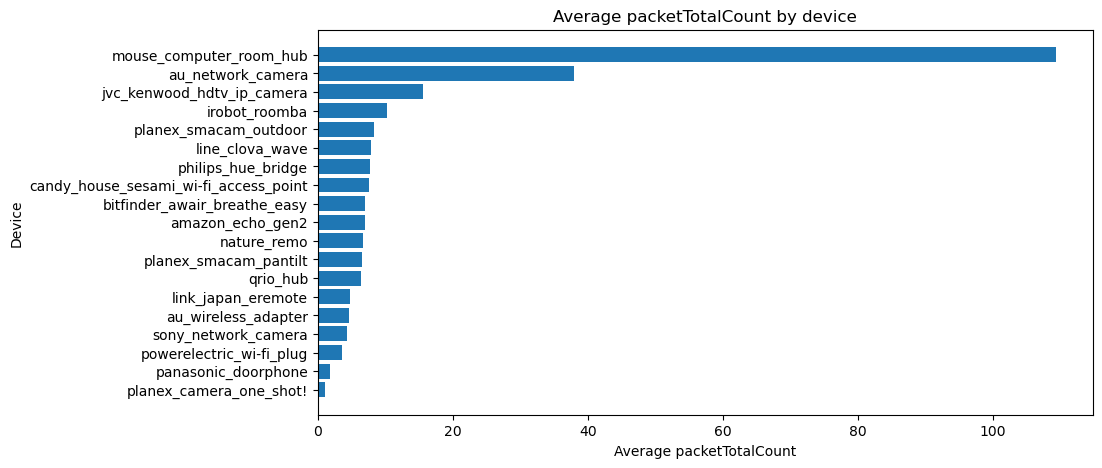

In [81]:
# Observing the mean packetTotalCount of each response

# Group the data by response and calculate the mean packetTotalCount for each group
packet_count_per_device = df[['response', 'packetTotalCount']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='packetTotalCount', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['packetTotalCount'])
ax.set_title('Average packetTotalCount by device')
ax.set_xlabel('Average packetTotalCount')
ax.set_ylabel('Device')
plt.show()

<Figure size 1200x700 with 0 Axes>

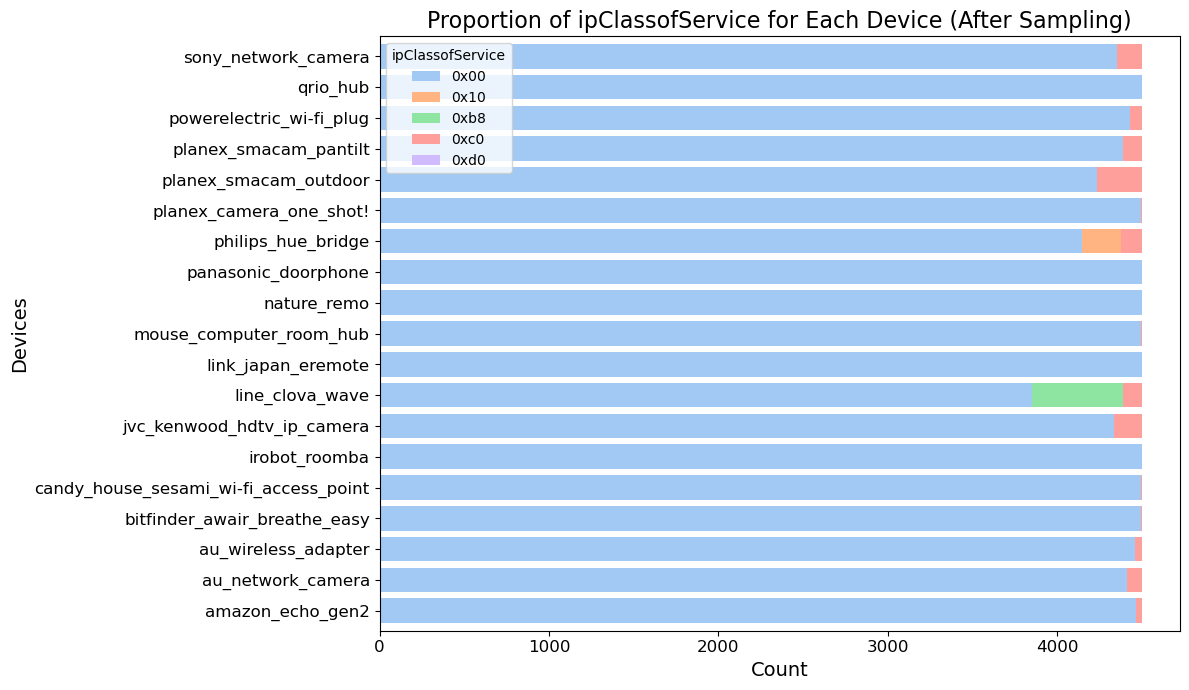

In [6]:
import seaborn as sns
pivot_df = df.groupby(['response', 'ipClassOfService']).size().unstack().fillna(0)


# Set a color palette (light-themed)

palette = sns.color_palette("pastel")

# Plot
plt.figure(figsize=(12, 7))

# Using the color palette in the stacked horizontal bar plot
pivot_df.plot(kind='barh', stacked=True, color=palette, figsize=(12, 7), width=0.8)

# Set title, labels, legend
plt.title('Proportion of ipClassofService for Each Device (After Sampling)', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Devices', fontsize=14)
plt.legend(title='ipClassofService', fontsize=10)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()



<Figure size 1200x700 with 0 Axes>

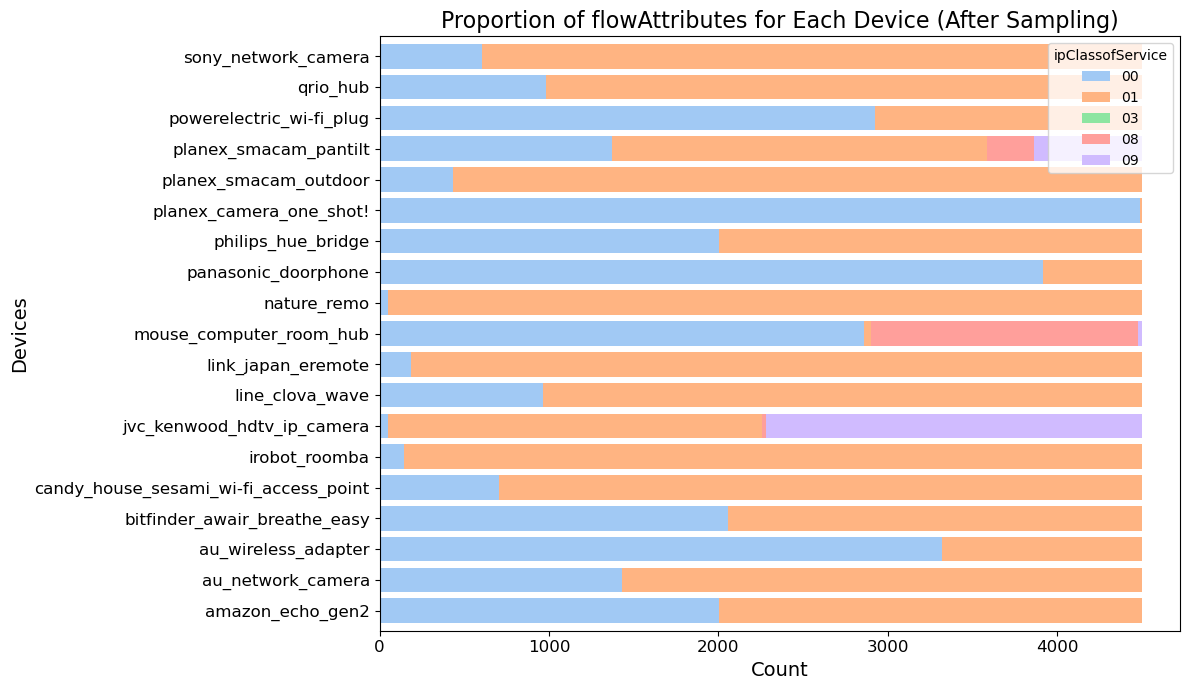

In [93]:
import seaborn as sns
pivot_df = df.groupby(['response', 'flowAttributes']).size().unstack().fillna(0)


# Set a color palette (light-themed)
palette = sns.color_palette("pastel")

# Plot
plt.figure(figsize=(12, 7))

# Using the color palette in the stacked horizontal bar plot
pivot_df.plot(kind='barh', stacked=True, color=palette, figsize=(12, 7), width=0.8)

# Set title, labels, legend
plt.title('Proportion of flowAttributes for Each Device (After Sampling)', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Devices', fontsize=14)
plt.legend(title='ipClassofService', fontsize=10)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


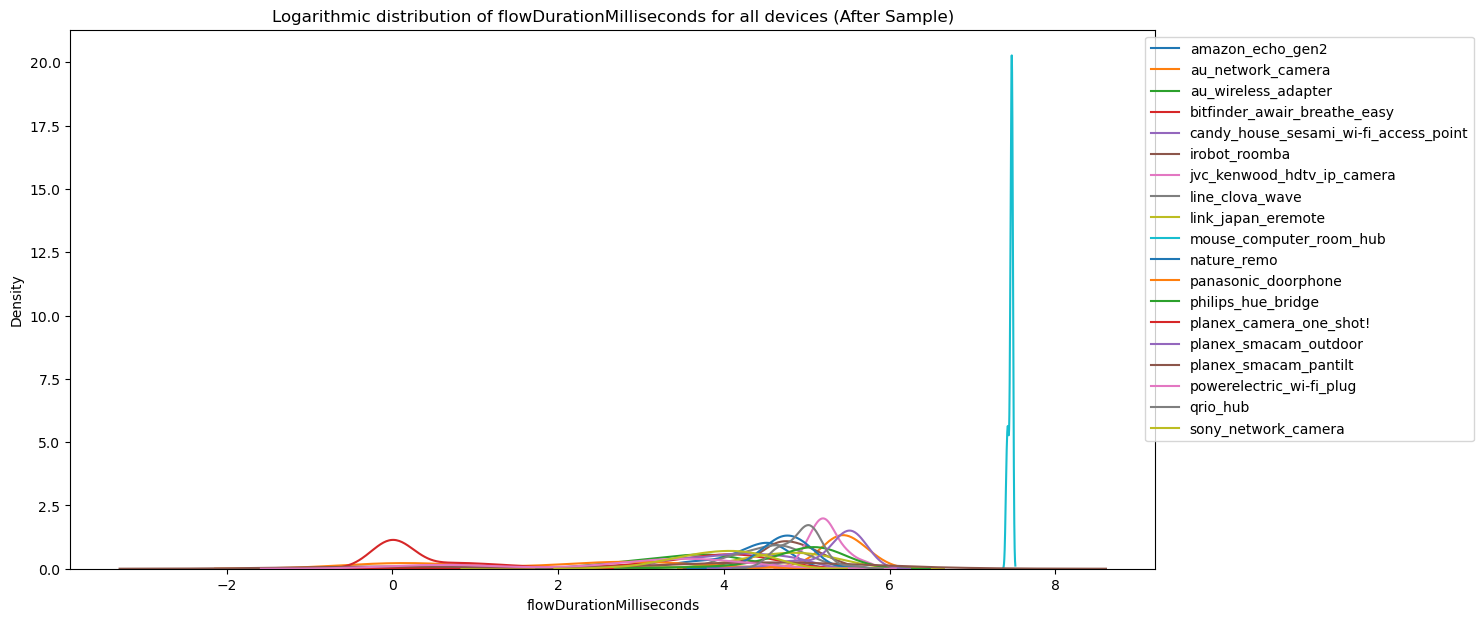

In [39]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Using kdeplots to plot distribution of flowDurationMilliseconds values
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
df['flowStartMilliseconds'] = pd.to_datetime(df['flowStartMilliseconds'])
flow_by_day = df.groupby(['response', pd.Grouper(key='flowStartMilliseconds', freq='D')])['flowDurationMilliseconds'].mean()
# Iterate over each unique device in the sample

for device in flow_by_day.index.get_level_values(0).unique():
    device_data = flow_by_day.loc[device].dropna()
    # Check if there are data points for the device
    if not device_data.empty:
        sns.kdeplot(np.log(device_data + 1), label=device)  # Added 1 to ensure all values are positive


ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Logarithmic distribution of flowDurationMilliseconds for all devices (After Sample)")
plt.show()

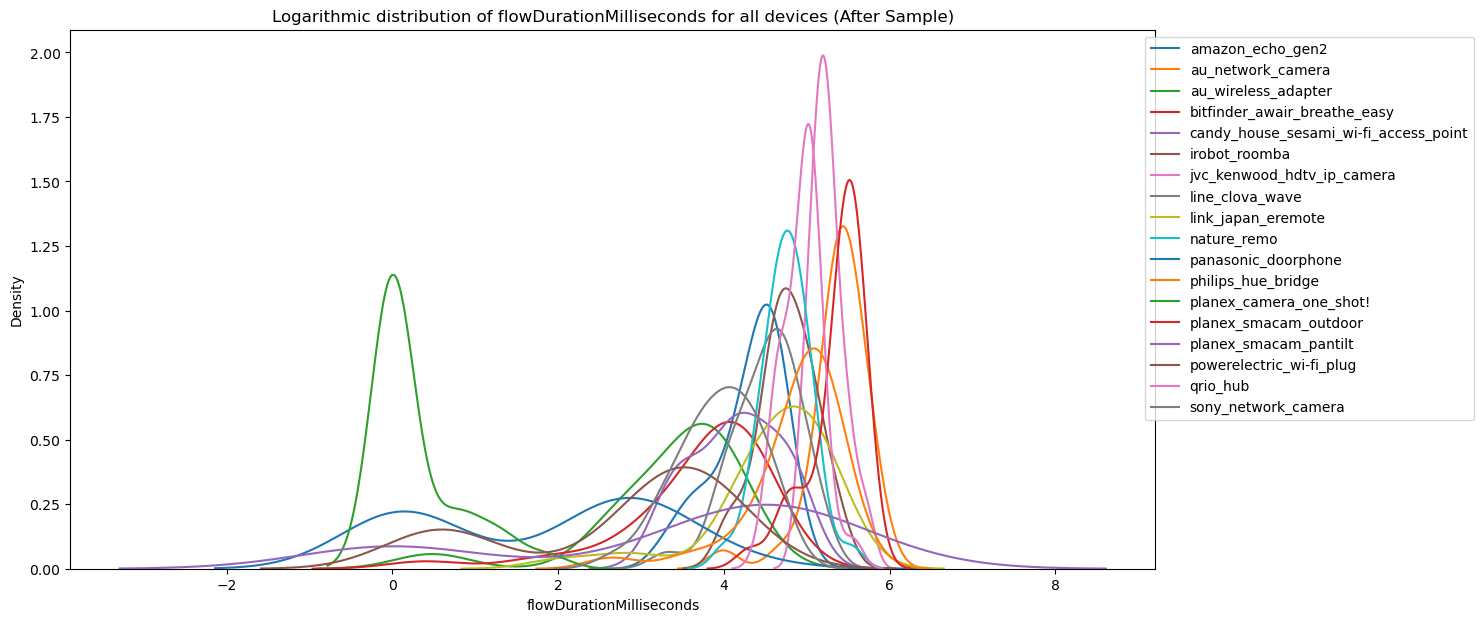

In [38]:

# Using kdeplots to plot distribution of flowDurationMilliseconds values
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
df['flowStartMilliseconds'] = pd.to_datetime(df['flowStartMilliseconds'])
flow_by_day = df.groupby(['response', pd.Grouper(key='flowStartMilliseconds', freq='D')])['flowDurationMilliseconds'].mean()
# Iterate over each unique device in the sample

for device in flow_by_day.index.get_level_values(0).unique():
    if device != 'mouse_computer_room_hub':
        device_data = flow_by_day.loc[device].dropna()

        # Check if there are data points for the device
        if not device_data.empty:
            sns.kdeplot(np.log(device_data + 1), label=device)  # Added 1 to ensure all values are positive


ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Logarithmic distribution of flowDurationMilliseconds for all devices (After Sample)")
plt.show()


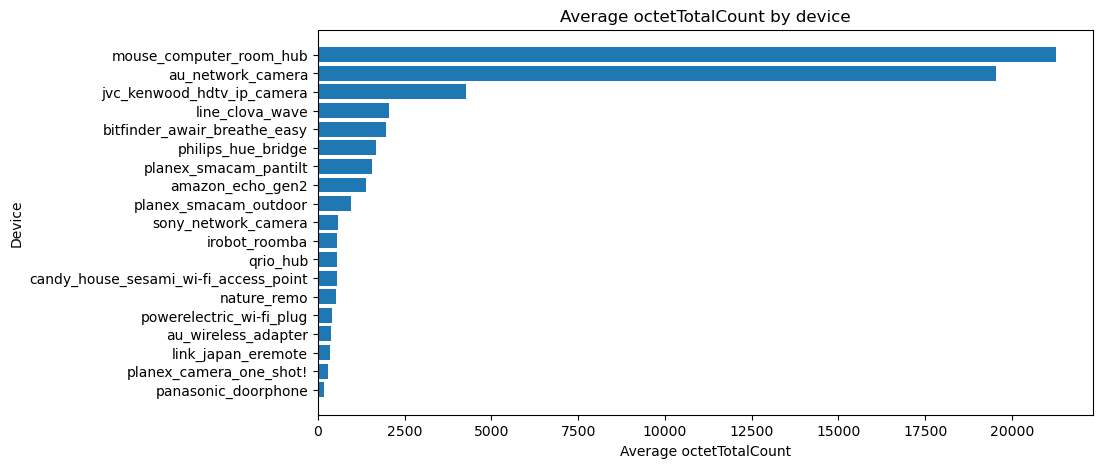

In [48]:
# Observing the mean octetTotalCount of each response

# Group the data by response and calculate the mean packetTotalCount for each group
packet_count_per_device = df[['response', 'octetTotalCount']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='octetTotalCount', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['octetTotalCount'])
ax.set_title('Average octetTotalCount by device')
ax.set_xlabel('Average octetTotalCount')
ax.set_ylabel('Device')
plt.show()

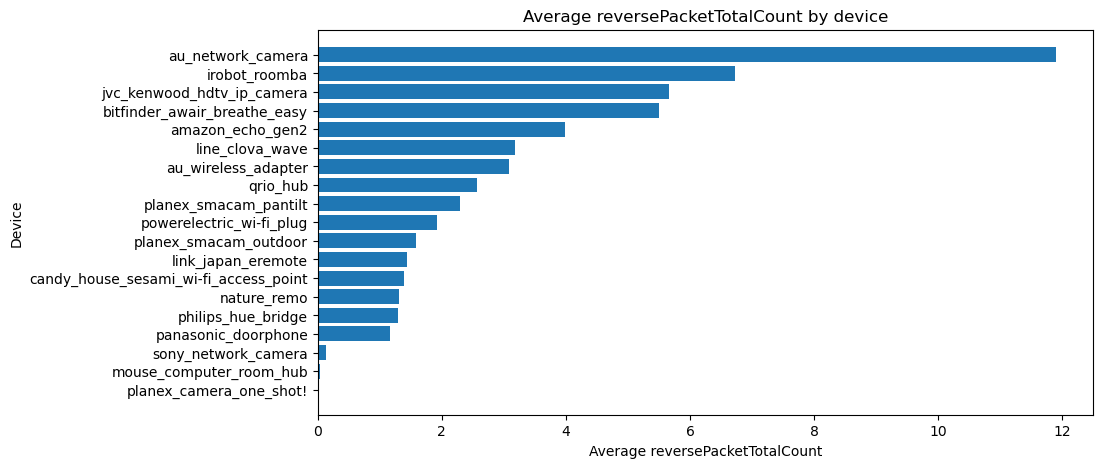

In [49]:
# Observing the mean reversePacketTotalCount of each response

# Group the data by response and calculate the mean packetTotalCount for each group
packet_count_per_device = df[['response', 'reversePacketTotalCount']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='reversePacketTotalCount', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['reversePacketTotalCount'])
ax.set_title('Average reversePacketTotalCount by device')
ax.set_xlabel('Average reversePacketTotalCount')
ax.set_ylabel('Device')
plt.show()

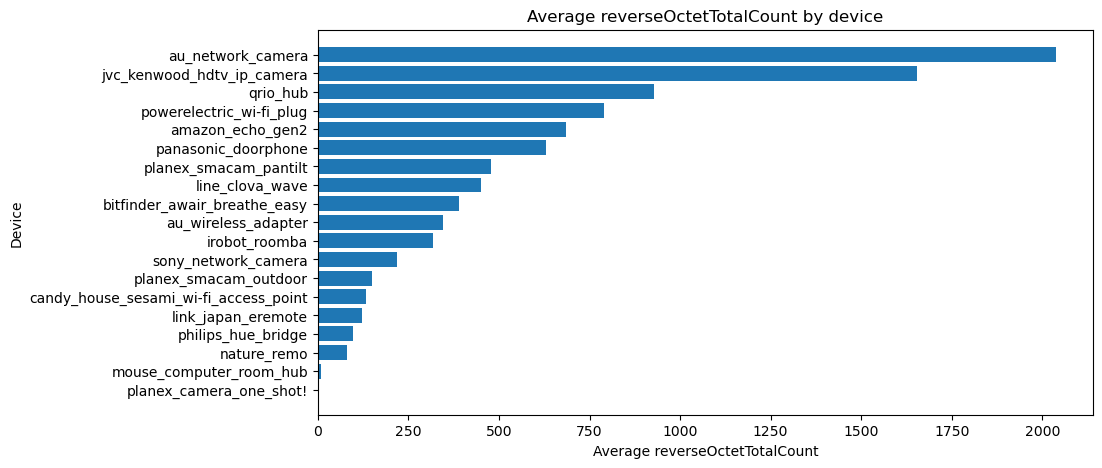

In [50]:
# Observing the mean reverseOctetTotalCount of each response

# Group the data by response and calculate the mean packetTotalCount for each group
packet_count_per_device = df[['response', 'reverseOctetTotalCount']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='reverseOctetTotalCount', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['reverseOctetTotalCount'])
ax.set_title('Average reverseOctetTotalCount by device')
ax.set_xlabel('Average reverseOctetTotalCount')
ax.set_ylabel('Device')
plt.show()

<Figure size 1200x700 with 0 Axes>

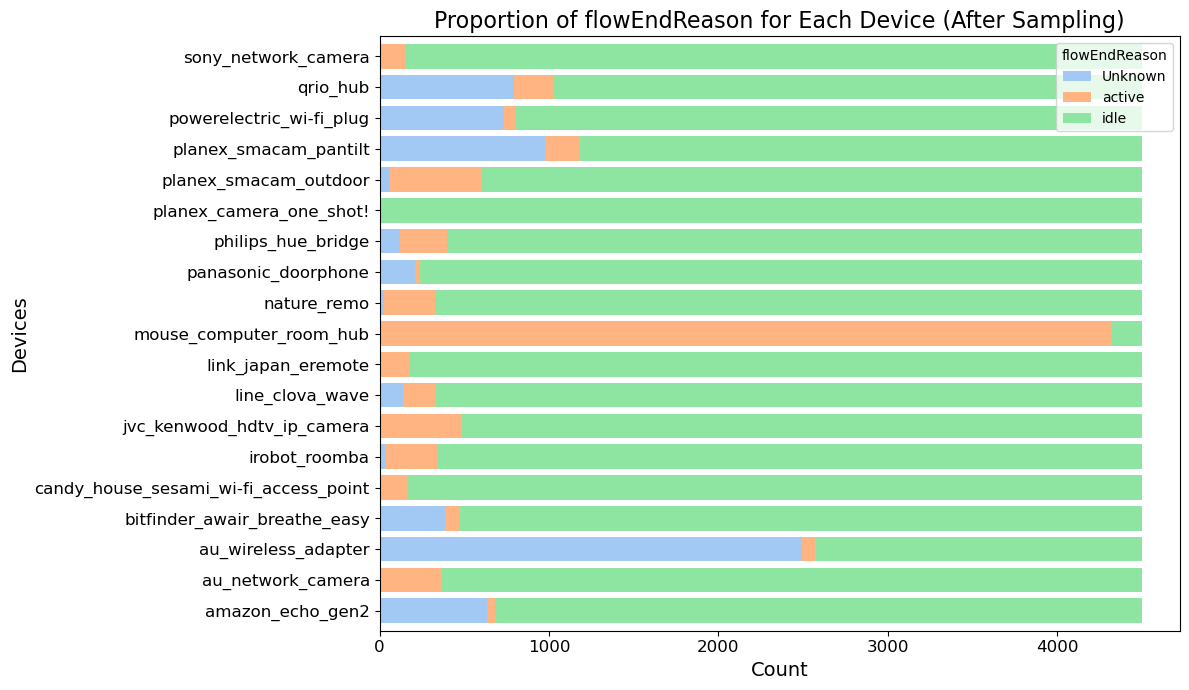

In [64]:
df['flowEndReason'].replace('', 'Unknown', inplace=True)
pivot_df = df.groupby(['response', 'flowEndReason']).size().unstack().fillna(0)


# Set a color palette (light-themed)
palette = sns.color_palette("pastel")

# Plot
plt.figure(figsize=(12, 7))

# Using the color palette in the stacked horizontal bar plot
pivot_df.plot(kind='barh', stacked=True, color=palette, figsize=(12, 7), width=0.8)

# Set title, labels, legend
plt.title('Proportion of flowEndReason for Each Device (After Sampling)', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Devices', fontsize=14)
plt.legend(title='flowEndReason', fontsize=10)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


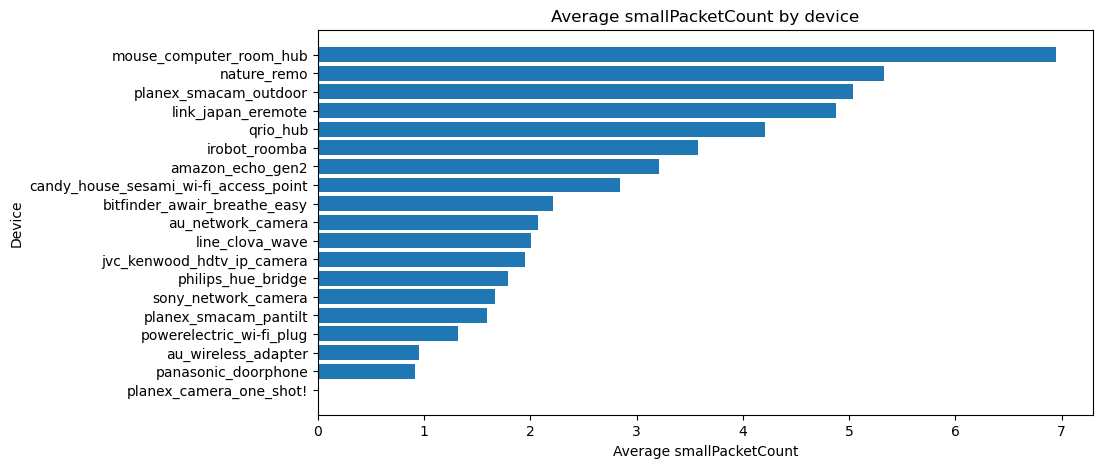

In [66]:
# Observing the mean smallPacketCount of each response

# Group the data by response and calculate the mean packetTotalCount for each group
packet_count_per_device = df[['response', 'smallPacketCount']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='smallPacketCount', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['smallPacketCount'])
ax.set_title('Average smallPacketCount by device')
ax.set_xlabel('Average smallPacketCount')
ax.set_ylabel('Device')
plt.show()

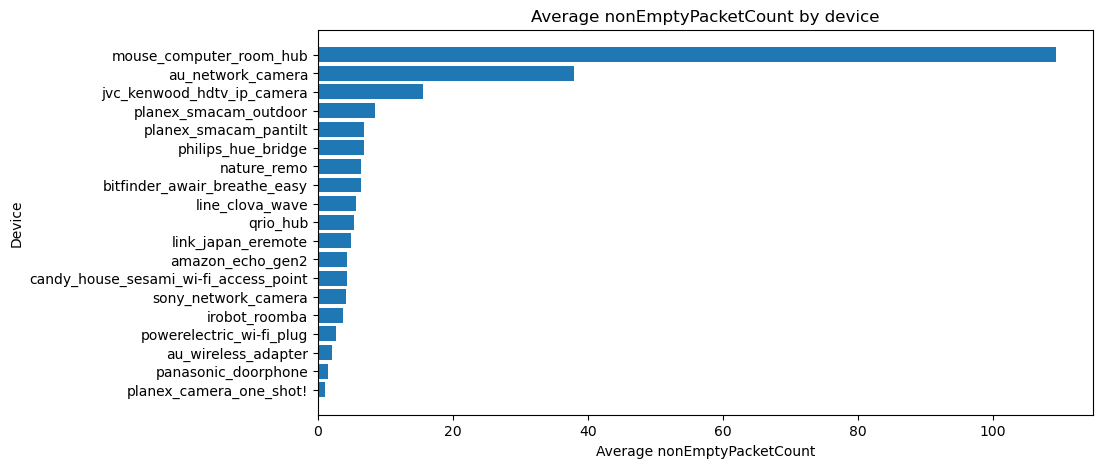

In [68]:
# Observing the mean nonEmptyPacketCount of each response

# Group the data by response and calculate the mean nonEmptyPacketCount for each group
packet_count_per_device = df[['response', 'nonEmptyPacketCount']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='nonEmptyPacketCount', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['nonEmptyPacketCount'])
ax.set_title('Average nonEmptyPacketCount by device')
ax.set_xlabel('Average nonEmptyPacketCount')
ax.set_ylabel('Device')
plt.show()

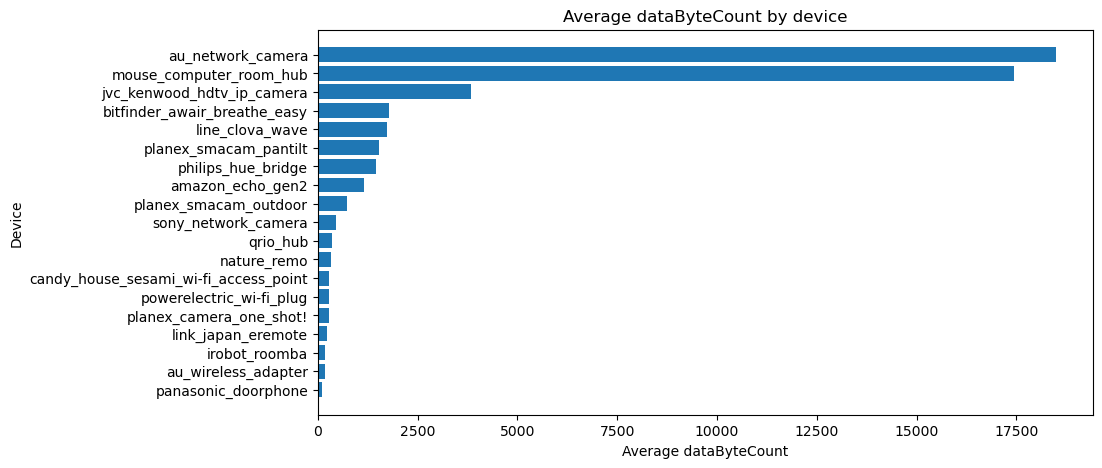

In [70]:
# Observing the mean dataByteCount of each response

# Group the data by response and calculate the mean dataByteCount for each group
packet_count_per_device = df[['response', 'dataByteCount']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='dataByteCount', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['dataByteCount'])
ax.set_title('Average dataByteCount by device')
ax.set_xlabel('Average dataByteCount')
ax.set_ylabel('Device')
plt.show()

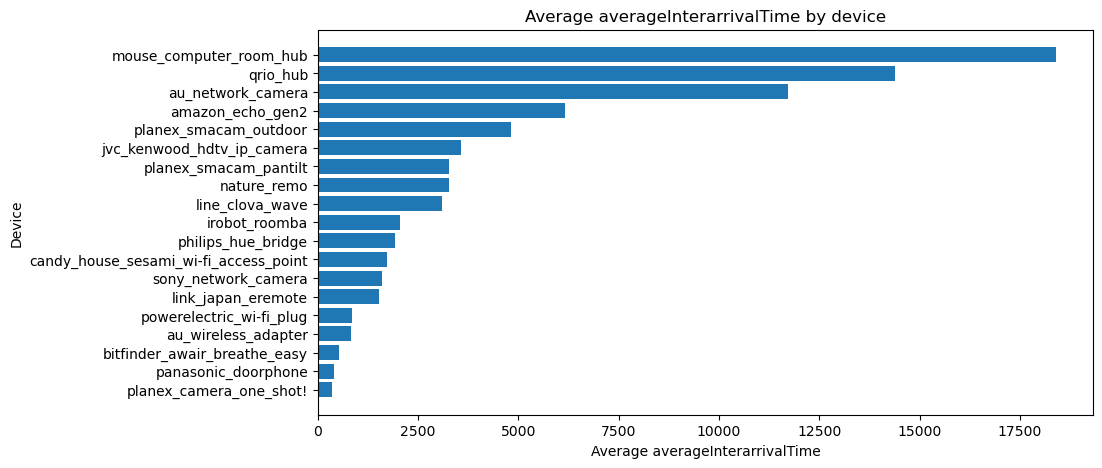

In [72]:
# Observing the mean averageInterarrivalTime of each response

# Group the data by response and calculate the mean averageInterarrivalTime for each group
packet_count_per_device = df[['response', 'averageInterarrivalTime']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='averageInterarrivalTime', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['averageInterarrivalTime'])
ax.set_title('Average averageInterarrivalTime by device')
ax.set_xlabel('Average averageInterarrivalTime')
ax.set_ylabel('Device')
plt.show()

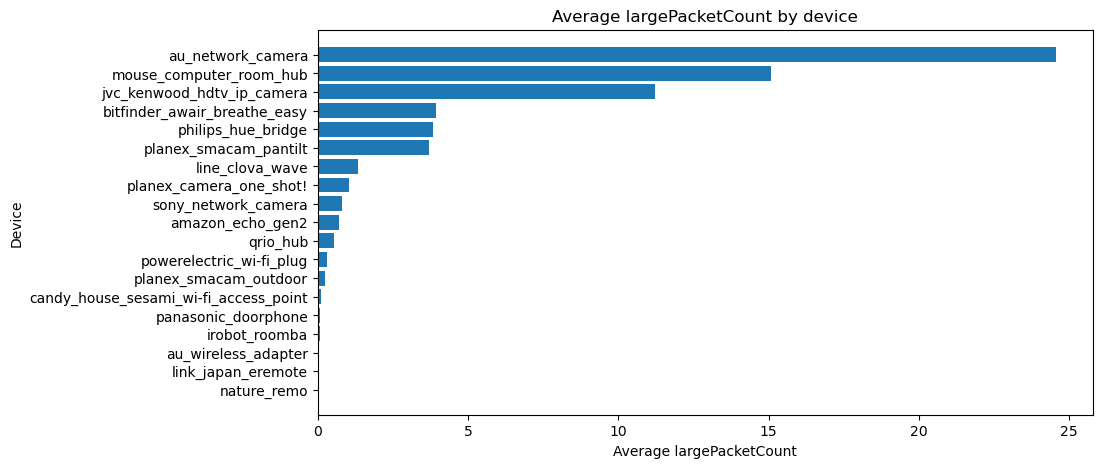

In [75]:
# Observing the mean largePacketCount of each response

# Group the data by response and calculate the mean largePacketCount for each group
packet_count_per_device = df[['response', 'largePacketCount']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='largePacketCount', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['largePacketCount'])
ax.set_title('Average largePacketCount by device')
ax.set_xlabel('Average largePacketCount')
ax.set_ylabel('Device')
plt.show()

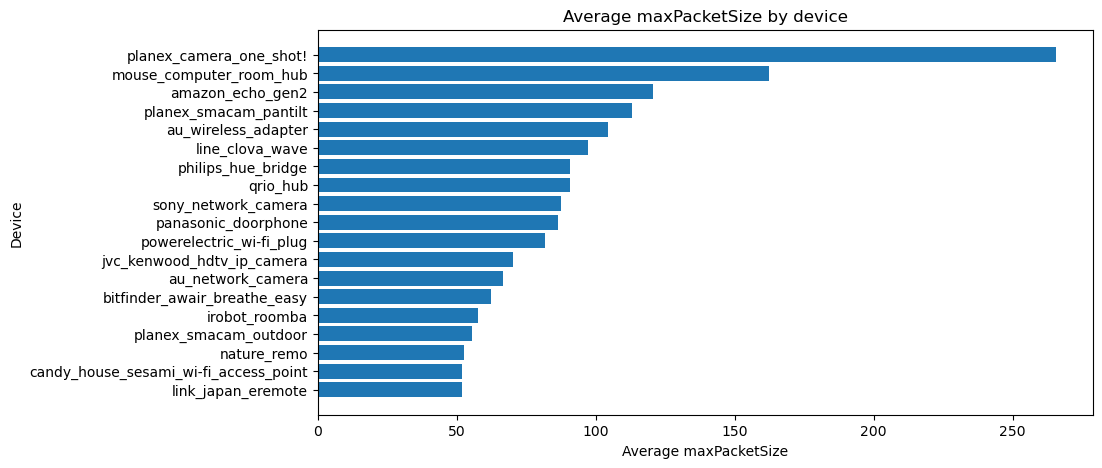

In [77]:
# Observing the mean maxPacketSize of each response

# Group the data by response and calculate the mean maxPacketSize for each group
packet_count_per_device = df[['response', 'maxPacketSize']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='maxPacketSize', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['maxPacketSize'])
ax.set_title('Average maxPacketSize by device')
ax.set_xlabel('Average maxPacketSize')
ax.set_ylabel('Device')
plt.show()

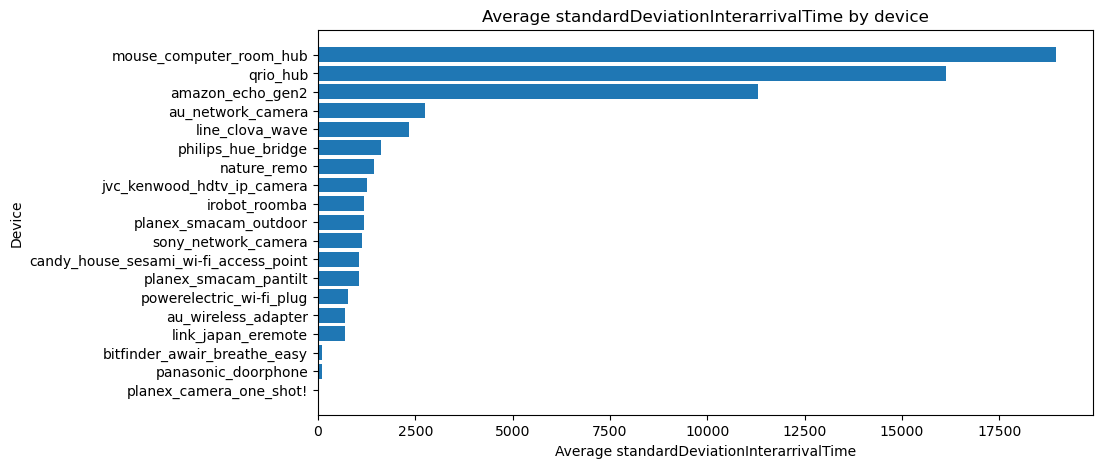

In [80]:
# Observing the mean standardDeviationInterarrivalTime of each response

# Group the data by response and calculate the mean standardDeviationInterarrivalTime for each group
packet_count_per_device = df[['response', 'standardDeviationInterarrivalTime']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='standardDeviationInterarrivalTime', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['standardDeviationInterarrivalTime'])
ax.set_title('Average standardDeviationInterarrivalTime by device')
ax.set_xlabel('Average standardDeviationInterarrivalTime')
ax.set_ylabel('Device')
plt.show()

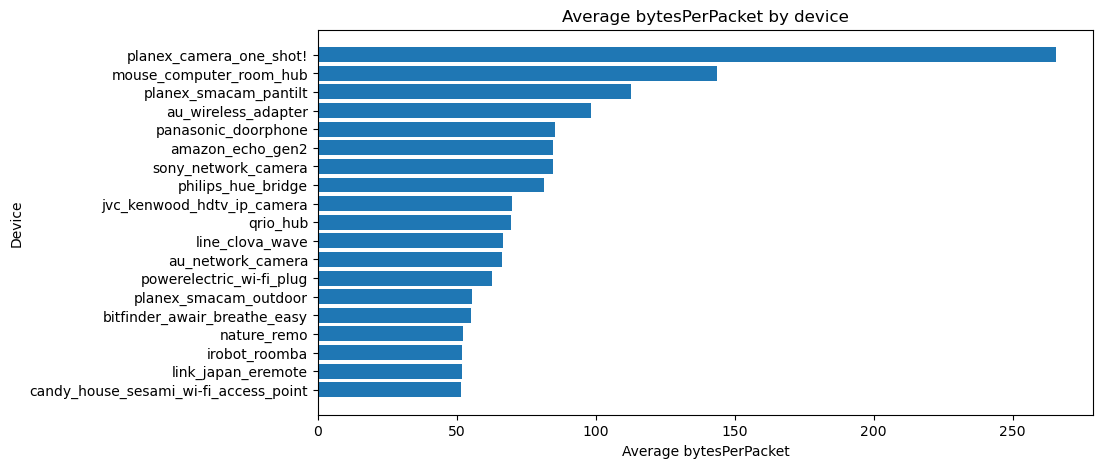

In [81]:
# Observing the mean bytesPerPacket of each response

# Group the data by response and calculate the mean bytesPerPacket for each group
packet_count_per_device = df[['response', 'bytesPerPacket']].groupby('response').mean()
packet_count_per_device = packet_count_per_device.sort_values(by='bytesPerPacket', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(packet_count_per_device.index, packet_count_per_device['bytesPerPacket'])
ax.set_title('Average bytesPerPacket by device')
ax.set_xlabel('Average bytesPerPacket')
ax.set_ylabel('Device')
plt.show()

In [80]:
df.columns

Index(['flowStartMilliseconds', 'flowEndMilliseconds',
       'flowDurationMilliseconds', 'reverseFlowDeltaMilliseconds',
       'protocolIdentifier', 'sourceTransportPort', 'packetTotalCount',
       'octetTotalCount', 'flowAttributes', 'destinationTransportPort',
       'reversePacketTotalCount', 'reverseOctetTotalCount',
       'reverseFlowAttributes', 'ipClassOfService', 'flowEndReason',
       'smallPacketCount', 'nonEmptyPacketCount', 'dataByteCount',
       'averageInterarrivalTime', 'firstNonEmptyPacketSize',
       'largePacketCount', 'maxPacketSize',
       'firstEightNonEmptyPacketDirections', 'standardDeviationPayloadLength',
       'standardDeviationInterarrivalTime', 'bytesPerPacket', 'response'],
      dtype='object')

In [82]:
df['bytesPerPacket'].unique()

array([  56.,  753.,  146.,   32.,   50.,   41.,  190.,   47.,   36.,
         44.,   43.,  564.,  228.,   48.,   80.,  759.,   nan,   46.,
        139.,  142.,   31.,   53.,   37.,   76.,  241.,  186.,  225.,
        636.,  226.,  174.,  546.,  358.,  231.,   40.,   20.,  203.,
        194.,  300.,  383.,  150.,  227.,  119.,  574.,  373.,  185.,
       1371.,  232.,  159.,  719.,  533.,  153.,  236.,  376.,  363.,
        941.,  189.,  188.,  494.,  657.,  124.,  949.,  262., 1408.,
        138.,  268.,   68., 1521.,  652.,   91., 1556., 1500.,  381.,
        148.,  368.,  263.,  641.,  157.,  123., 1466.,  271.,  107.,
        155.,  187.,  365.,  191.,  121., 1571.,  152.,  230.,  162.,
       1491.,  169.,  475.,  384.,  462.,  160., 1461.,   95.,   78.,
        288.,   45.,   42.,   29.,  316.,  606.,  630.,  284.,  602.,
        280.,   33.,  599.,   72.,  133.,  106.,  369.,   35.,  716.,
        771.,  370.,  406.,   60.,   63.,  707.,   61.,  252.,  432.,
        884.,  789.,

In [12]:
df

,flowStartMilliseconds,flowEndMilliseconds,flowDurationMilliseconds,reverseFlowDeltaMilliseconds,protocolIdentifier,sourceTransportPort,packetTotalCount,octetTotalCount,flowAttributes,destinationTransportPort,...,nonEmptyPacketCount,dataByteCount,averageInterarrivalTime,firstNonEmptyPacketSize,largePacketCount,maxPacketSize,firstEightNonEmptyPacketDirections,standardDeviationPayloadLength,standardDeviationInterarrivalTime,bytesPerPacket
0,2019-06-27 21:53:01.806,2019-06-27 21:53:01.826,0.020,0.000,1,0,10,840,01,0,...,10.0,560.0,2.0,56.0,0.0,56.0,00,0.0,1.0,56.0
1,2019-07-13 19:47:21.040,2019-07-13 19:49:26.611,125.571,0.174,6,46185,23,4777,00,443,...,5.0,3765.0,498.0,517.0,4.0,1360.0,7e,411.0,467.0,753.0
2,2019-07-10 11:16:20.373,2019-07-10 11:21:20.736,300.363,0.176,6,51448,9,684,01,80,...,2.0,292.0,37523.0,146.0,0.0,146.0,0e,0.0,90712.0,146.0
3,2019-07-04 04:29:36.366,2019-07-04 04:34:36.783,300.417,0.178,6,34505,9,684,01,80,...,2.0,292.0,37530.0,146.0,0.0,146.0,0e,0.0,90666.0,146.0
4,2019-07-12 01:10:42.809,2019-07-12 01:10:52.801,9.992,0.000,17,23600,2,120,01,53,...,2.0,64.0,9992.0,32.0,0.0,32.0,00,0.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85495,2019-07-07 14:18:39.536,2019-07-07 14:18:40.111,0.575,0.000,17,38298,2,156,01,137,...,2.0,100.0,575.0,50.0,0.0,50.0,00,0.0,0.0,50.0
85496,2019-07-25 18:53:55.947,2019-07-25 18:53:56.534,0.587,0.000,17,45093,2,156,01,137,...,2.0,100.0,587.0,50.0,0.0,50.0,00,0.0,0.0,50.0
85497,2019-07-15 18:31:11.745,2019-07-15 18:31:11.936,0.191,0.000,17,52323,6,1958,00,1900,...,6.0,1790.0,38.0,282.0,6.0,322.0,00,17.0,32.0,298.0
85498,2019-07-24 19:37:10.067,2019-07-24 19:37:10.647,0.580,0.000,17,60684,2,156,01,137,...,2.0,100.0,580.0,50.0,0.0,50.0,00,0.0,0.0,50.0


In [ ]:
df.count()